For each dataset (2 HR, 2 SR, 4 SLO):

    - For each model (XLM-R-base, XLM-R-large, CSEBert, SloBERTa, BERTić, multiple versions of XLM-R-BERTić and XLM-R-SloBERTić):


        - fine-tune the model and evaluate it - 5 times

## Setup and Dataset Importing

In [6]:
# Define the gpu on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

import evaluate
from datetime import datetime
import pandas as pd
import numpy as np
import json
from simpletransformers.ner import NERModel, NERArgs
from sklearn.metrics import classification_report, f1_score
from tqdm.autonotebook import tqdm as notebook_tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import logging
import sklearn
from numba import cuda
import argparse
import gc
import torch
import time

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
# Import the dataset

# Code for python script
"""
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("dataset", help="path to the dataset in JSON format")
    args = parser.parse_args()

# Define the path to the dataset
dataset_path = args.dataset
"""
# Define the path to the dataset
dataset_path = "datasets/hr500k.conllup_extracted.json"

# Load the json file
with open(dataset_path, "r") as file:
    json_dict = json.load(file)

# Open the train, eval and test dictionaries as DataFrames
train_df = pd.DataFrame(json_dict["train"])
test_df = pd.DataFrame(json_dict["test"])
dev_df = pd.DataFrame(json_dict["dev"])

# Change the sentence_ids to numbers
test_df['sentence_id'] = pd.factorize(test_df['sentence_id'])[0]
train_df['sentence_id'] = pd.factorize(train_df['sentence_id'])[0]
dev_df['sentence_id'] = pd.factorize(dev_df['sentence_id'])[0]

# Define the labels
LABELS = json_dict["labels"]
print(LABELS)

print(train_df.shape, test_df.shape, dev_df.shape)
print(train_df.head())



['O', 'B-loc', 'B-org', 'B-per', 'I-per', 'B-deriv-per', 'I-org', 'I-loc', 'B-misc', 'I-misc', 'I-deriv-per']
(398681, 3) (51190, 3) (49764, 3)
     sentence_id      words labels
717            0      Kazna      O
718            0  medijskom      O
719            0     mogulu      O
720            0   obnovila      O
721            0   raspravu      O


## Training code

In [19]:
def train_and_test(model, train_df, test_df, dataset_path, LABELS):

    # Define the model

    # Define the model arguments - use the same one as for XLM-R-large if model is based on it,
    # if the model is of same size as XLM-R-base, use its optimal hyperparameters (I searched for them before)
    xlm_r_large_args = {"overwrite_output_dir": True,
                "num_train_epochs": 5,
                "labels_list": LABELS,
                "learning_rate": 1e-5,
                "train_batch_size": 32,
                # Comment out no_cache and no_save if you want to save the model
                "no_cache": True,
                "no_save": True,
                "max_seq_length": 256,
                "save_steps": -1,
                "silent": True,
                }

    xlm_r_base_args = {"overwrite_output_dir": True,
             "num_train_epochs": 9,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": 32,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
             "max_seq_length": 256,
             "save_steps": -1,
            "silent": True,
             }


    # Model type - a dictionary of type and model name.
    # To refer to our own models, use the path to the model directory as the model name.
    model_type_dict = {
        "sloberta": ["camembert", "EMBEDDIA/sloberta", xlm_r_base_args],
        "csebert": ["bert", "EMBEDDIA/crosloengual-bert", xlm_r_base_args],
        "xlm-r-base": ["xlmroberta", "xlm-roberta-base", xlm_r_base_args],
        "xlm-r-large": ["xlmroberta", "xlm-roberta-large", xlm_r_large_args],
        "bertic": ["electra", "classla/bcms-bertic", xlm_r_base_args],
        "xlmrb_bcms_12": ["xlmroberta", "models/xlmrb_bcms_12", xlm_r_base_args],
        "xlmrl_bcms_48000": ["xlmroberta", "output", xlm_r_large_args]
    }

    # Update the hyperparameters accordingly to the model
    model_args = model_type_dict[model][2]

    if "bcms" in model:
        model_path = model_type_dict[model][1]
        model_args["output_dir"] = "models/{}/".format(model)
        model_args["no_save"] = False
        model_args["num_train_epoch"] = 1

    # Define the model
    current_model = NERModel(
    model_type_dict[model][0],
    model_type_dict[model][1],
    labels = LABELS,
    use_cuda=True,
    args = model_args)

    print("Training started. Current model: {}".format(model))
    start_time = time.time()

    # Fine-tune the model
    current_model.train_model(train_df)

    print("Training completed.")

    training_time = round((time.time() - start_time)/60,2)

    print("It took {} minutes for {} instances.".format(training_time, train_df.shape[0]))

    # Clean cache
    gc.collect()
    torch.cuda.empty_cache()

    start_evaluation_time = time.time()

    # Evaluate the model
    results = current_model.eval_model(test_df)

    print("Evaluation completed.")

    evaluation_time = round((time.time() - start_evaluation_time)/60,2)

    print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))

    # Get predictions
    preds = results[1]

    # Create a list with predictions
    preds_list = []

    for sentence in preds:
        for word in sentence:
            current_word = []
            for element in word:
                # Find prediction with the highest value
                highest_index = element.index(max(element))
                # Transform the index to label
                current_pred = current_model.config.id2label[highest_index]
                # Append to the list
                current_word.append(current_pred)
            # Segmentation can result in multiple predictions for one word - use the first prediction only
            preds_list.append(current_word[0])
    
    # Get y_true
    y_true = list(test_df.labels)

    run_name = "{}-{}".format(dataset_path, model)

    # Evaluate predictions
    metrics = evaluate.testing(y_true, preds_list, list(test_df.labels.unique()), run_name, show_matrix=True)

    # Add y_pred and y_true to the metrics dict
    metrics["y_true"] = y_true
    metrics["y_pred"] = preds_list

    # Let's also add entire results
    metrics["results_output"] = results    
    
    # The function returns a dict with accuracy, micro f1, macro f1, y_true and y_pred
    return metrics

In [25]:
# Create lists of all needed models for the task
base_dict = {"/cache/nikolal/xlmrb_bcms_exp/checkpoint-12000": "xlmrb_bcms-12", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-24000": "xlmrb_bcms-24", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-36000": "xlmrb_bcms-36", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-48000": "xlmrb_bcms-48", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-60000": "xlmrb_bcms-60", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-72000": "xlmrb_bcms-72", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-84000": "xlmrb_bcms-84", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-96000": "xlmrb_bcms-96"}
large_dict = {"/cache/nikolal/xlmrl_bcms_exp/checkpoint-6000": "xlmrl_bcms-6", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-12000":"xlmrl_bcms-12", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-18000": "xlmrl_bcms-18", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-24000": "xlmrl_bcms-24", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-30000": "xlmrl_bcms-30", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-36000": "xlmrl_bcms-36", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-42000": "xlmrl_bcms-42", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-48000": "xlmrl_bcms-48", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-6000": "xlmrl_sl-bcms-6", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-12000": "xlmrl_sl-bcms-12", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-18000": "xlmrl_sl-bcms-18", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-24000": "xlmrl_sl-bcms-24", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-30000": "xlmrl_sl-bcms-30", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-42000": "xlmrl_sl-bcms-42", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-48000": "xlmrl_sl-bcms-48"}

base_list = list(base_dict.keys())
large_list = list(large_dict.keys())
large_list

['/cache/nikolal/xlmrl_bcms_exp/checkpoint-6000',
 '/cache/nikolal/xlmrl_bcms_exp/checkpoint-12000',
 '/cache/nikolal/xlmrl_bcms_exp/checkpoint-18000',
 '/cache/nikolal/xlmrl_bcms_exp/checkpoint-24000',
 '/cache/nikolal/xlmrl_bcms_exp/checkpoint-30000',
 '/cache/nikolal/xlmrl_bcms_exp/checkpoint-36000',
 '/cache/nikolal/xlmrl_bcms_exp/checkpoint-42000',
 '/cache/nikolal/xlmrl_bcms_exp/checkpoint-48000',
 '/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-6000',
 '/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-12000',
 '/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-18000',
 '/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-24000',
 '/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-30000',
 '/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-42000',
 '/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-48000']

In [29]:
print(list(large_dict.values()))

['xlmrl_bcms-6', 'xlmrl_bcms-12', 'xlmrl_bcms-18', 'xlmrl_bcms-24', 'xlmrl_bcms-30', 'xlmrl_bcms-36', 'xlmrl_bcms-42', 'xlmrl_bcms-48', 'xlmrl_sl-bcms-6', 'xlmrl_sl-bcms-12', 'xlmrl_sl-bcms-18', 'xlmrl_sl-bcms-24', 'xlmrl_sl-bcms-30', 'xlmrl_sl-bcms-42', 'xlmrl_sl-bcms-48']
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [16]:
def train_and_save_checkpoint(model_path, model_size, train_df, test_df, dataset_path, LABELS):
	# When fine-tuning our custom models that we pre-trained, and using them from checkpoints, the process is a bit different than with publicly available models: first, we need to fine-tune a model from the original checkpoint, so that we save the model and overwrite its original settings which force pretraining from a specific step (and disable fine-tuning by that). Then we take that new model and fine-tune it, as we did with the models before. 

	# Create lists of all needed models for the task
	path_list = {"/cache/nikolal/xlmrb_bcms_exp/checkpoint-12000": "xlmrb_bcms-12", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-24000": "xlmrb_bcms-24", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-36000": "xlmrb_bcms-36", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-48000": "xlmrb_bcms-48", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-60000": "xlmrb_bcms-60", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-72000": "xlmrb_bcms-72", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-84000": "xlmrb_bcms-84", "/cache/nikolal/xlmrb_bcms_exp/checkpoint-96000": "xlmrb_bcms-96", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-6000": "xlmrl_bcms-6", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-12000":"xlmrl_bcms-12", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-18000": "xlmrl_bcms-18", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-24000": "xlmrl_bcms-24", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-30000": "xlmrl_bcms-30", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-36000": "xlmrl_bcms-36", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-42000": "xlmrl_bcms-42", "/cache/nikolal/xlmrl_bcms_exp/checkpoint-48000": "xlmrl_bcms-48", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-6000": "xlmrl_sl-bcms-6", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-12000": "xlmrl_sl-bcms-12", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-18000": "xlmrl_sl-bcms-18", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-24000": "xlmrl_sl-bcms-24", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-30000": "xlmrl_sl-bcms-30", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-42000": "xlmrl_sl-bcms-42", "/cache/nikolal/xlmrl_sl-bcms_exp/checkpoint-48000": "xlmrl_sl-bcms-48"}

	# Define the model arguments - use the same one as for XLM-R-large if model is based on it,
	# if the model is of same size as XLM-R-base, use its optimal hyperparameters (I searched for them before)
	xlm_r_large_args = {"overwrite_output_dir": True,
			"num_train_epochs": 5,
			"labels_list": LABELS,
			"learning_rate": 1e-5,
			"train_batch_size": 32,
			# Comment out no_cache and no_save if you want to save the model
			"no_cache": True,
			"no_save": True,
			"max_seq_length": 256,
			"save_steps": -1,
			"silent": True,
			}

	xlm_r_base_args = {"overwrite_output_dir": True,
			"num_train_epochs": 9,
			"labels_list": LABELS,
			"learning_rate": 1e-5,
			"train_batch_size": 32,
			# Comment out no_cache and no_save if you want to save the model
			"no_cache": True,
			"no_save": True,
			"max_seq_length": 256,
			"save_steps": -1,
			"silent": True,
			}
	
	if model_size == "base":
		# Update the hyperparameters accordingly to the model
		model_args = xlm_r_base_args
	elif model_size == "large":
		model_args = xlm_r_large_args

	# Add additional arguments, specific for our own models
	# Specify the folder where we want to save the models
	new_model_path = path_list[model_path]
	model_args["output_dir"] = "models/{}/".format(new_model_path)
	model_args["no_save"] = False
	model_args["num_train_epoch"] = 1

	# Define the model
	current_model = NERModel(
	"xlmroberta",
	model_path,
	labels = LABELS,
	use_cuda=True,
	args = model_args)

	print("Training started. Current model: {}".format(model))
	start_time = time.time()

	# Fine-tune the model
	current_model.train_model(train_df)

	print("Training completed.")

	print("Model saved as models/{}/".format(new_model_path))

	# Clean cache
	gc.collect()
	torch.cuda.empty_cache()




In [ ]:

	#start_evaluation_time = time.time()

	# Evaluate the model
	#results = current_model.eval_model(test_df)

	#print("Evaluation completed.")

	#evaluation_time = round((time.time() - start_evaluation_time)/60,2)

	#print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))

	# Get predictions
	#preds = results[1]

	# Create a list with predictions
	#preds_list = []

	for sentence in preds:
		for word in sentence:
			current_word = []
			for element in word:
				# Find prediction with the highest value
				highest_index = element.index(max(element))
				# Transform the index to label
				current_pred = current_model.config.id2label[highest_index]
				# Append to the list
				current_word.append(current_pred)
			# Segmentation can result in multiple predictions for one word - use the first prediction only
			preds_list.append(current_word[0])

	# Get y_true
	y_true = list(test_df.labels)

	run_name = "{}-{}".format(dataset_path, model)

	# Evaluate predictions
	metrics = evaluate.testing(y_true, preds_list, list(test_df.labels.unique()), run_name, show_matrix=True)

	# Add y_pred and y_true to the metrics dict
	metrics["y_true"] = y_true
	metrics["y_pred"] = preds_list

	# Let's also add entire results
	metrics["results_output"] = results    

	# The function returns a dict with accuracy, micro f1, macro f1, y_true and y_pred
	return metrics

In [20]:
# Testing the models if they work as expected
model_list = ["xlmrb_bcms_12"]

for model in model_list:
	current_results_dict = train_and_test(model, train_df, test_df, dataset_path, LABELS)

	print("Run finished.")

Training started. Current model: xlmrb_bcms_12


INFO:simpletransformers.ner.ner_model: Converting to features started.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

INFO:simpletransformers.ner.ner_model:   Starting fine-tuning.


Running Epoch 0 of 9:   0%|          | 0/619 [00:00<?, ?it/s]

/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 9:   0%|          | 0/619 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
ner_list = dir(NERArgs)

import torch

optimizer_state = torch.load("model/checkpoint-48000/training_args.bin")

attributes = list(dir(optimizer_state))


# Find the intersection of the sets
common_elements = list(set(attributes).intersection(set(ner_list)))

print(common_elements)

In [ ]:
print(optimizer_state.resume_from_checkpoint)

In [ ]:
optimizer_state.warmup_ratio = 0.06
optimizer_state.learning_rate = 1e-5
optimizer_state.fp16 = True
optimizer_state.logging_steps = 50
#optimizer_state.n_gpu = 1
optimizer_state.gradient_accumulation_steps = 1
optimizer_state.output_dir = "outputs/"
optimizer_state.num_train_epochs = 1
optimizer_state.resume_from_checkpoint = True
optimizer_state.ignore_data_skip = True


# Save arguments with new attributes
torch.save(optimizer_state, "model/checkpoint-48000/training_args.bin")

In [7]:
# Create a new file for results
#with open("ner-results-our-models.txt", "w") as file:
#    file.write("Date\tModel\tRun\tDataset\tMicro F1\tMacro F1\tLabel Report\n")

In [ ]:
# Testing the models if they work as expected
# models: ["xlm-r-large", "sloberta", "csebert", "xlm-r-base", "bertic"]
model = "xlmrl-bcms-48"
run = "test"

current_results_dict = train_and_test(model, train_df, test_df, dataset_path)

# Add to the dict model name, dataset name and run
current_results_dict["model"] = model
current_results_dict["run"] = "{}-{}".format(model, run)
current_results_dict["dataset"] = dataset_path

# Add to the file with results all important information
#with open("ner-results-testing.txt", "a") as file:
#    file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["Micro F1 Nikola"], current_results_dict["Macro F1 Nikola"], current_results_dict["label-report"]))

# Add to the original test_df y_preds
#test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

# Save entire dict just in case
#with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
#    json.dump(current_results_dict, backlog, indent=2)

print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
#test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))

# Result Analysis

In [2]:
# Import the txt with results
import pandas as pd

results = pd.read_csv("ner-results.txt", sep="\t")

results

,Date,Model,Run,Dataset,Micro F1,Macro F1,Label Report
0,18/08/2023 16:39:46,xlm-r-large,xlm-r-large-0,datasets/hr500k.conllup_extracted.json,0.990291,0.918266,{'B-deriv-per': {'precision': 0.92105263157894...
1,18/08/2023 16:54:08,xlm-r-large,xlm-r-large-1,datasets/hr500k.conllup_extracted.json,0.990350,0.920143,{'B-deriv-per': {'precision': 0.92307692307692...
2,18/08/2023 17:40:13,xlm-r-base,xlm-r-base-0,datasets/hr500k.conllup_extracted.json,0.988611,0.909217,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
3,18/08/2023 17:50:32,xlm-r-base,xlm-r-base-1,datasets/hr500k.conllup_extracted.json,0.988572,0.903684,{'B-deriv-per': {'precision': 0.91891891891891...
4,19/08/2023 08:51:35,xlm-r-base,xlm-r-base-0,datasets/set.sr.plus.conllup_extracted.json,0.988355,0.886370,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
5,19/08/2023 08:53:43,xlm-r-base,xlm-r-base-1,datasets/set.sr.plus.conllup_extracted.json,0.988005,0.855162,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
6,22/08/2023 09:38:41,xlmrb_bcms-12,xlmrb_bcms-12-0,datasets/hr500k.conllup_extracted.json,0.989627,0.914450,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
7,22/08/2023 09:49:10,xlmrb_bcms-12,xlmrb_bcms-12-1,datasets/hr500k.conllup_extracted.json,0.989646,0.913838,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
8,22/08/2023 10:00:03,xlmrb_bcms-24,xlmrb_bcms-24-0,datasets/hr500k.conllup_extracted.json,0.989666,0.916545,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
9,22/08/2023 10:10:20,xlmrb_bcms-24,xlmrb_bcms-24-1,datasets/hr500k.conllup_extracted.json,0.989549,0.915471,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."


<Axes: xlabel='Model'>

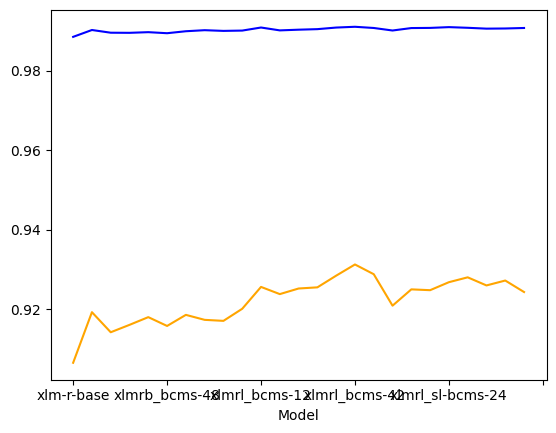

In [3]:
# Get average micro and macro F1
dataset = "datasets/hr500k.conllup_extracted.json"

# Define the dataset to inspect
import matplotlib as plt
results[results["Dataset"] == dataset].groupby("Model")["Micro F1"].mean().plot(kind="line", color="blue")
results[results["Dataset"] == dataset].groupby("Model")["Macro F1"].mean().plot(kind="line",color="orange")

In [4]:
results[results["Dataset"] == dataset].groupby("Model")["Macro F1"].mean().round(2)

results["Macro F1"] = results["Macro F1"].round(2)

# Pivot the DataFrame to rearrange columns into rows
pivot_df = results.pivot(index='Run', columns='Dataset', values='Macro F1')

# Reset the index to have 'Model' as a column
pivot_df.reset_index(inplace=True)

pivot_df

Dataset,Run,datasets/hr500k.conllup_extracted.json,datasets/set.sr.plus.conllup_extracted.json
0,xlm-r-base-0,0.91,0.89
1,xlm-r-base-1,0.90,0.86
2,xlm-r-large-0,0.92,NaN
3,xlm-r-large-1,0.92,NaN
4,xlmrb_bcms-12-0,0.91,NaN
5,xlmrb_bcms-12-1,0.91,NaN
6,xlmrb_bcms-24-0,0.92,NaN
7,xlmrb_bcms-24-1,0.92,NaN
8,xlmrb_bcms-36-0,0.92,NaN
9,xlmrb_bcms-36-1,0.92,NaN


In [5]:
# Pivot the DataFrame to rearrange columns into rows
pivot_df.to_csv("ner-results-summary-table.csv")

In [ ]:
# Let's analyze the df with all the predictions
import numpy as np

pred_df = pd.read_csv("datasets/hr500k.conllup_extracted.json-test_df-with-predictions.csv", index_col = 0)

# Analyze instances where models are wrong
pred_df["match"] = np.where(pred_df["labels"] != pred_df["y_pred_xlm-r-large_0"], "no", "yes")
pred_df.match.value_counts()

In [ ]:
pred_df[pred_df["match"] == "no"]